# Deep Neural Network

In [3]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from IPython.display import display

from data_processing import prepare_data, split_data
from helper_functions import get_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

In [4]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Milestone 1: Basic model

Train on 2944 samples, validate on 982 samples
Epoch 1/30
2944/2944 [==============================] - 0s 155us/sample - loss: 0.2229 - accuracy: 0.9538 - val_loss: 0.2155 - val_accuracy: 0.9470
Epoch 2/30
2944/2944 [==============================] - 0s 37us/sample - loss: 0.1893 - accuracy: 0.9562 - val_loss: 0.2048 - val_accuracy: 0.9450
Epoch 3/30
2944/2944 [==============================] - 0s 34us/sample - loss: 0.1815 - accuracy: 0.9555 - val_loss: 0.2130 - val_accuracy: 0.9470
Epoch 4/30
2944/2944 [==============================] - 0s 32us/sample - loss: 0.1786 - accuracy: 0.9545 - val_loss: 0.2376 - val_accuracy: 0.9287
Epoch 5/30
2944/2944 [==============================] - 0s 30us/sample - loss: 0.1757 - accuracy: 0.9541 - val_loss: 0.2041 - val_accuracy: 0.9470
Epoch 6/30
2944/2944 [==============================] - 0s 39us/sample - loss: 0.1743 - accuracy: 0.9538 - val_loss: 0.2235 - val_accuracy: 0.9470
Epoch 7/30
2944/2944 [==============================] - 0s 39us/sample

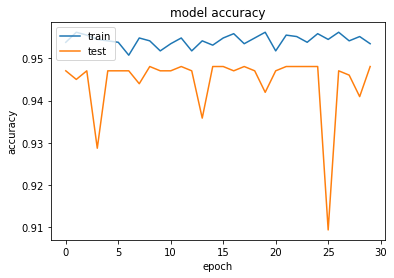

train metrics: 

accuracy: 95.8560 % 

balanced accuracy: 50.0000 %
sensitivity: 0.0
specificity: 1.0 

confusion matrix: 
[[2822    0]
 [ 122    0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 94.8065 % 

balanced accuracy: 50.0000 %
sensitivity: 0.0
specificity: 1.0 

confusion matrix: 
[[931   0]
 [ 51   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [5]:
def train_and_predict(model, training_data, training_labels, testing_data, testing_labels, epochs=5):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. It is possible to adjust for how many epochs the model is trained
    """
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, validation_data=(testing_data, testing_labels))

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

    return predictions_train, predictions_test

# Get the amount of input features for the nodes in the first layer
input_shape = np.shape(train_data)[1]

# Create the model
model = models.Sequential()

# First layer with input nodes equal to features
model.add(Input(shape=(input_shape)))

# One hidden layer with 25 nodes
model.add(layers.Dense(25, activation='relu'))

# Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
model.add(layers.Dense(1, 'sigmoid'))

# Train and predict
predictions_train, predictions_test = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        epochs=30)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



### Milestone 2: Actual model
##### Additions:
1. Weighted loss to increase sensitivity to stroke cases.
2. keep metrics of 

In [ ]:
def train_and_predict(model, training_data, training_labels, testing_data, testing_labels, epochs=5):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. It is possible to adjust for how many epochs the model is trained
    """
    # metrics to store each epoch:
    TP = TruePositives()
    FP = FalsePositives()
    TN = TrueNegatives()
    FN = FalseNegatives()
    
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy', TP, FP, TN, FN])
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        #class_weights={training_labels.unique()[0]: 1., training_labels.unique()[1]: 10.}
                       )

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

    return predictions_train, predictions_test, history

# Get the amount of input features for the nodes in the first layer
input_shape = np.shape(train_data)[1]

# Create the model
model = models.Sequential()

# First layer with input nodes equal to features
model.add(Input(shape=(input_shape)))

# One hidden layer with 25 nodes
model.add(layers.Dense(25, activation='relu'))

# Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
model.add(layers.Dense(2, 'softmax'))

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        epochs=30)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



In [ ]:
# Calculate balanced accuracy by hand in order to plot balanced accuracy over epochs

TP = np.array(history.history['true_positives_1'])
TN = np.array(history.history['true_negatives_1'])
FP = np.array(history.history['false_positives_1'])
FN = np.array(history.history['false_negatives_1'])

bal_acc = (TP / (TP + FN) + TN / (FP + TN)) / 2

plt.plot(bal_acc)
plt.title('model balanced accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
